In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import re
#from scipy.optimize import curve_fit
#import mdtraj as md
import os

In [3]:
def dir_to_trajs(directory):
    """
    loads atom positions from all LAMMPS files in given directory
    
    input directory: path of directory e.g. run3-100_dumplin (string)
    output: positions of all atoms at different times (numpy array) 
    """
    a = []
    # iterate over files in
    # that directory
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        # checking if it is a file: 
        if os.path.isfile(f):
            a.append(np.loadtxt(f, skiprows=9, usecols=(1,2,3)))
    
    return np.asarray(a[-round(len(a)/2):])#[a[-125],a[-1]]

In [4]:
def calcMSDs(directory,delta=1,samplesize=100,refatom=None,cutoff=np.inf):
    trajs = dir_to_trajs(directory)
    MSDs = []
    errs = []
    if refatom == None:
        for gendist in range(1,trajs.shape[1],delta):
            a = []
            try:
                refatoms = np.random.choice(range(trajs.shape[1]-gendist), size=samplesize, replace=False)
            except:
                refatoms = range(trajs.shape[1]-gendist)
            for atom1 in refatoms:
                temp = trajs[:,atom1]-trajs[:,atom1+gendist]
                a.append(np.linalg.norm(temp, axis=1)**2)
            allSDs = np.asarray(a)
            MSD, err = np.mean(allSDs), np.std(allSDs, ddof=1) / np.sqrt(np.size(allSDs))
            MSDs.append(MSD)
            errs.append(err)
            
    else:
        for gendist in range(1,min(trajs.shape[1]-(refatom-1),cutoff),delta):
            temp = trajs[:,refatom-1]-trajs[:,refatom-1+gendist]
            allSDs = np.linalg.norm(temp, axis=1)**2
            MSD, err = np.mean(allSDs), np.std(allSDs, ddof=1) / np.sqrt(np.size(allSDs))
            MSDs.append(MSD)
            errs.append(err)
    
    return np.asarray(MSDs), np.asarray(errs)

In [5]:
def plotMSDs(directory,delta=1,samplesize=100,refatom=None,compareruns=False):
    if compareruns == False:
        runs = directory.split('/')[-1]
        MSDs, errs = calcMSDs(directory,delta,samplesize,refatom)
        gendists = delta*np.arange(1, len(MSDs)+1)
        plt.errorbar(gendists, MSDs, yerr=errs, fmt=',', linestyle='None') # pixel marker and no line
    elif compareruns == True:
        runs = ''
        for count,directory in enumerate(directory):
            runs += directory.split('/')[-1]
            MSDs, errs = calcMSDs(directory,delta,samplesize,refatom)
            gendists = delta*np.arange(1, len(MSDs)+1)
            plt.errorbar(gendists, MSDs, yerr=errs, fmt=',', linestyle='None', label=directory.split('/')[-1]) # pixel marker and no line
        plt.legend(loc='upper left')
    
    if refatom == None:
        plt.title(r'MSD $\left\langle r^2 \right\rangle$ as a function of genomic distance')
    else:
        plt.title(r'MSD $\left\langle r^2 \right\rangle$ as a function of genomic distance'+'\n'+'atom No '+str(refatom)+' is the reference')
    plt.xlabel(r'Genomic distance [bp]')
    plt.ylabel(r'$\left\langle r^2 \right\rangle$')
    
    plt.grid()
    plt.tight_layout()
    plt.savefig('../plots/'+'MSDvsgendist_'+runs+'_delta'+str(delta)+'_ssize'+str(samplesize)+'.pdf', format='pdf')
    plt.show()

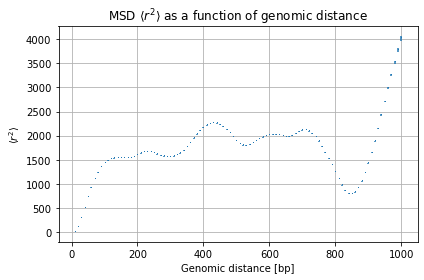

CPU times: user 2.22 s, sys: 40.4 ms, total: 2.26 s
Wall time: 2.25 s


In [9]:
%%time
directory = '../run2-1000/dumplin_K45'
delta = 10 # difference in gendist between adjacent data points in the plot
samplesize = 1000 # No of randomly chosen pairs of atoms from which MSD is calculated for each gendist
plotMSDs(directory,delta,samplesize,compareruns=False)

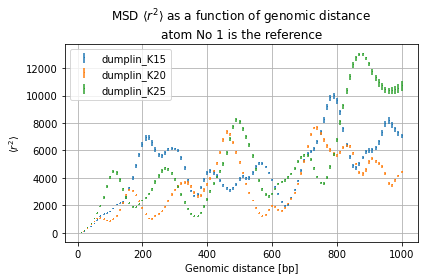

Wall time: 6.74 s


In [71]:
%%time
directory = ['../simdata/dumplin_K15', '../simdata/dumplin_K20', '../simdata/dumplin_K25']
delta = 10 # difference in gendist between adjacent data points in the plot
#samplesize = 100 # No of randomly chosen pairs of atoms from which MSD is calculated for each gendist
ref = 1
plotMSDs(directory,delta,refatom=ref,compareruns=True)

In [52]:
def plotMSDs_avgruns(directory,delta=1,samplesize=100,refatom=None):
    allMSDs = []
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        # checking if it is a directory:
        if os.path.isdir(f):
            for file in os.listdir(f):
                dumplin = os.path.join(f, file)
                if os.path.isdir(dumplin):
                    allMSDs.append(calcMSDs(dumplin,delta,samplesize,refatom)[0])
            
    avgMSDs = np.mean(np.asarray(allMSDs), axis=0)
    errs = np.std(np.asarray(allMSDs), axis=0) / np.sqrt(len(allMSDs))
    gendists = delta*np.arange(1, len(avgMSDs)+1)
    
    if refatom==None:
        plt.title(r'MSD $\left\langle r^2 \right\rangle$ as a fct of gendist averaged over '+str(len(allMSDs))+' runs')
    else:
        plt.title(r'MSD $\left\langle r^2 \right\rangle$ as a fct of gendist averaged over '+str(len(allMSDs))+' runs\n'+'atom No '+str(refatom)+' is the reference')
    plt.xlabel(r'Genomic distance [bp]')
    plt.ylabel(r'$\left\langle r^2 \right\rangle$')
    plt.errorbar(gendists, avgMSDs, yerr=errs, fmt='.', linestyle='None') # , pixel marker or . point marker and no line
    plt.grid()
    plt.tight_layout()
    #plt.savefig('../plots/'+'avgMSDvsgendist_'+directory.split('/')[-1]+'_delta'+str(delta)+'_ssize'+str(samplesize)+'.pdf', format='pdf')
    plt.show()

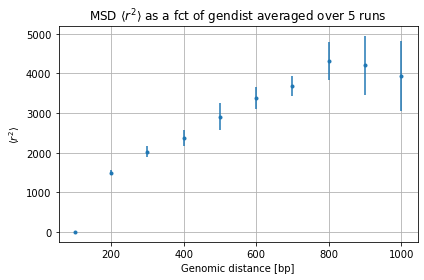

Wall time: 10.8 s


In [53]:
%%time
directory = '../simdata/runs1000'
delta = 100 # difference in gendist between adjacent data points in the plot
#samplesize = 100 # No of randomly chosen pairs of atoms from which MSD is calculated for each gendist
plotMSDs_avgruns(directory,delta)

In the following example, one atom (the reference atom) is fixed throughout the whole calculation.

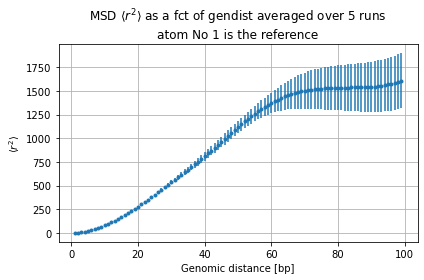

Wall time: 10.7 s


In [7]:
%%time
directory = '../simdata/runs100'
delta = 1
ref = 1
plotMSDs_avgruns(directory,delta,refatom=ref)

We now want to fix a subpolymer of given length and examine whether its behavior differs depending on the total chain length.

In [41]:
def plotsubpolymers(directories,delta=1,refatoms=np.ones(len(directories), dtype=np.int64),length=100):
    polymers = ''
    for count,directory in enumerate(directories):
        polymers += directory.split('/')[-1]
        allMSDs = []
        for filename in os.listdir(directory):
            # checking if it is a directory:
            f = os.path.join(directory, filename)
            if os.path.isdir(f):
                for file in os.listdir(f):
                    dumplin = os.path.join(f, file)
                    if os.path.isdir(dumplin):
                        allMSDs.append(calcMSDs(dumplin,delta,refatom=refatoms[count],cutoff=length)[0])
            
        avgMSDs = np.mean(np.asarray(allMSDs), axis=0)
        errs = np.std(np.asarray(allMSDs), axis=0) / np.sqrt(len(allMSDs))
        gendists = delta*np.arange(1, len(avgMSDs)+1)
    
        plt.errorbar(gendists, avgMSDs, yerr=errs, fmt='.', linestyle='None', label=directory.split('/')[-1]) # , pixel marker or . point marker and no line
    
    plt.title(r'Subpolymers of length '+str(length)+' for different total chain lengths\n'+'atom No '+str(refatoms)+' is the reference')
    plt.xlabel(r'Genomic distance [bp]')
    plt.ylabel(r'$\left\langle r^2 \right\rangle$')
    plt.legend(loc='upper left')
    plt.grid()
    plt.tight_layout()
    plt.savefig('../plots/'+'subpolymers'+'_length'+str(length)+'_'+polymers+'_delta'+str(delta)+'_ref'+str(refatoms)+'.pdf', format='pdf')
    plt.show()

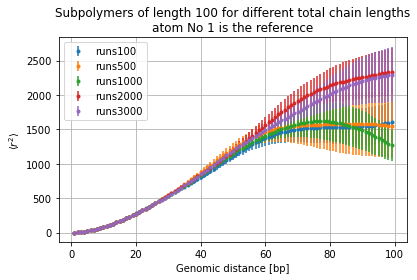

Wall time: 2min 29s


In [9]:
%%time
directories = ['../simdata/runs100','../simdata/runs500','../simdata/runs1000','../simdata/runs2000','../simdata/runs3000']
delta = 1
ref = 1
subpolymer_len = 100
plotsubpolymers(directories,delta,ref,subpolymer_len)

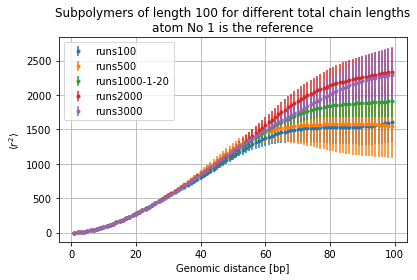

Wall time: 2min 12s


In [30]:
%%time
directories = ['../simdata/runs100','../simdata/runs500','../simdata/runs1000-1-20','../simdata/runs2000','../simdata/runs3000']
delta = 1
ref = 1
subpolymer_len = 100
plotsubpolymers(directories,delta,ref,subpolymer_len)

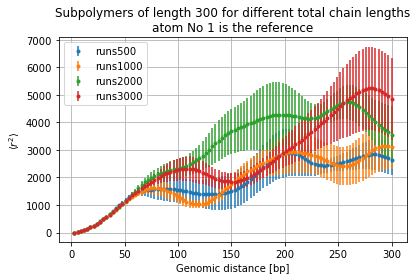

Wall time: 1min 36s


In [10]:
%%time
directories = ['../simdata/runs100','../simdata/runs500','../simdata/runs1000','../simdata/runs2000','../simdata/runs3000']
delta = 3
ref = 1
subpolymer_len = 300
plotsubpolymers(directories,delta,ref,subpolymer_len)

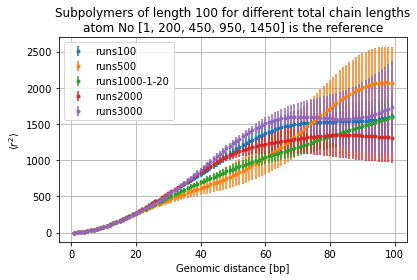

Wall time: 2min 19s


In [42]:
%%time
directories = ['../simdata/runs100','../simdata/runs500','../simdata/runs1000-1-20','../simdata/runs2000','../simdata/runs3000']
delta = 1
ref = [1,200,450,950,1450]
subpolymer_len = 100
plotsubpolymers(directories,delta,ref,subpolymer_len)

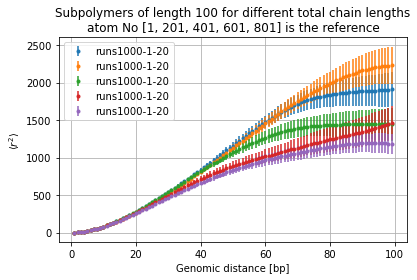

Wall time: 4min 9s


In [43]:
%%time
directories = ['../simdata/runs1000-1-20','../simdata/runs1000-1-20','../simdata/runs1000-1-20','../simdata/runs1000-1-20','../simdata/runs1000-1-20',]
delta = 1
ref = [1,201,401,601,801]
subpolymer_len = 100
plotsubpolymers(directories,delta,ref,subpolymer_len)